# Purpose:

This notebook provides code to regenerate all of the primary figures from cleaned data and tables included in the repository. 

Also this code contains the process of generating the Leiden communities from the SNP-distance networks. 

Conda environment is included in Github and should be activated before running this notebook.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as sp
from operator import itemgetter
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import sys
from scikit_posthocs import posthoc_dunn
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from Bio import pairwise2
import leidenalg as la
import math
import igraph
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.stats import spearmanr, pearsonr
from itertools import combinations
import igraph as ig

/Users/iskander/opt/anaconda3/envs/1KGP_GIT/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# Figure 1:

In [73]:
k_df = pd.read_csv('fig_data/Supplemental_Table_1.csv', index_col=0)
k_counts = k_df[[k for k in k_df.columns[0:126] if "/" in k]].T

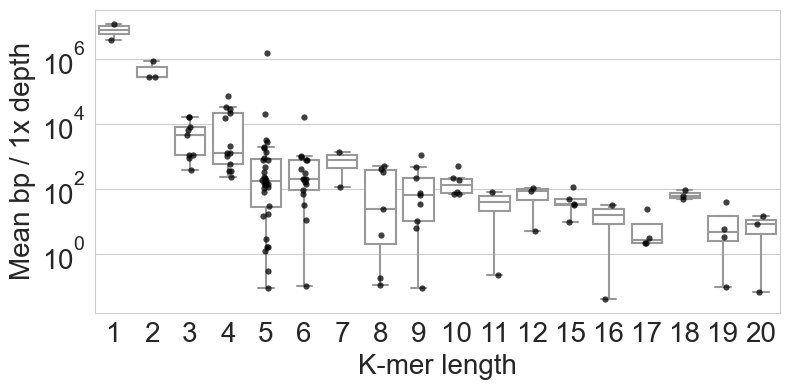

In [65]:
mean_bps = np.mean(k_counts, axis=1)
length = [len(i.split("/")[0]) for i in k_counts.index]

copy_df = pd.DataFrame(data={"mean":mean_bps, "length":length})


with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(8, 4))
    sns.stripplot(data=copy_df, x="length", y="mean", color='black',alpha=0.75, s=4.5)
    sns.boxplot(data=copy_df, x="length", y="mean", color='white', showfliers=False)
    #sns.violinplot(data=copy_df, x="length", y="mean", color='white', showfliers=False)
    
    plt.ylabel("Mean bp / 1x depth", fontsize=20)
    plt.xlabel("K-mer length", fontsize=20)
    plt.yscale("log", base=10)
    plt.xticks( fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    #plt.savefig("FIG_PLOT_DRAFTS/kmer_counts.png",dpi=300)
    plt.show()
    plt.close()

In [79]:
#get total bp by satellite class for each individual
k_length = [(len(k)-1)/2 for k in k_df.columns[0:126]]
total_bp = np.sum(k_df[[k for k in k_df.columns[0:126] ]] * k_length, axis=1)
k_df['total_bp'] = total_bp

k_bp = k_df[[k for k in k_df.columns[0:126] ]] * k_length

bp_perc = k_bp

In [80]:
#make summarized dataframe for plot
other_repeats = np.sum(bp_perc[[k for k in bp_perc.columns if k not in ["A/T", "AATGG/CCATT", "C/G", "AT/AT", "AG/CT", "AC/GT"]] ], axis=1)

#seperate repeats by A+G, AT+AG+AC and AATGG 
A_C = np.sum(bp_perc[["A/T", "C/G"]], axis=1)
AT_AG_AC = np.sum(bp_perc[["AT/AT", "AG/CT", "AC/GT"]], axis=1)

barplot_df = pd.DataFrame(data={})
barplot_df["AATGG"] = bp_perc['AATGG/CCATT']
#barplot_df["A+G"] = A_C
barplot_df["A"] = bp_perc["A/T"]
barplot_df["G"] = bp_perc["C/G"]
barplot_df["AT+AG+AC"] = AT_AG_AC
barplot_df["Other"] = other_repeats
barplot_df['sample'] = k_df.index

barplot_df = barplot_df[["A","AATGG", "G", "AT+AG+AC", "Other", 'sample']]
#barplot_df["pop"] = k_clean_df['pop']
#barplot_df["super_pop"] = k_clean_df['super_pop']

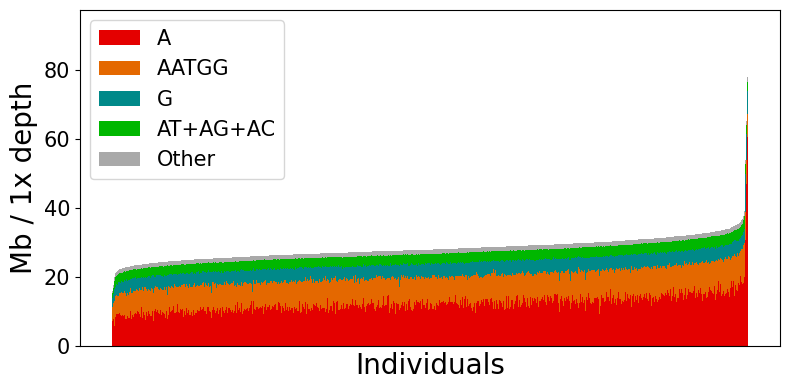

In [85]:
bplot_df = (barplot_df.iloc[np.argsort(np.sum(barplot_df[barplot_df.columns[0:5]],axis=1)),].set_index('sample') / 1000000)

fig = plt.figure(figsize=(8,4))

#colors = sns.color_palette('Set2', len(bplot_df.columns))[::-1]
colors=['#E40000', "#E46800", "#008989", "#00B700", "darkgrey"]

prev_k = []
index = 0
for kmer in bplot_df.columns:
    if len(prev_k) == 0:
        plt.bar(height=bplot_df[kmer], x=bplot_df.index, align='edge', width=1, color=colors[index])
    else:
        plt.bar(height=bplot_df[kmer], x=bplot_df.index, bottom=np.sum(bplot_df[prev_k],axis=1), align='edge', width=1
               , color=colors[index])

    prev_k.append(kmer)
    index += 1
#plt.yscale('log', base=5)
plt.yticks(fontsize=15)
plt.ylabel('Mb / 1x depth', fontsize=20)
plt.xlabel('Individuals', fontsize=20)
plt.legend(bplot_df.columns, fontsize=15, loc='upper left')
ticks = plt.xticks(ticks=[], labels=[])
plt.tight_layout()
#plt.savefig('FIG_PLOT_DRAFTS/individual.kmer.abundance.png', dpi=300)
plt.show()
plt.close()


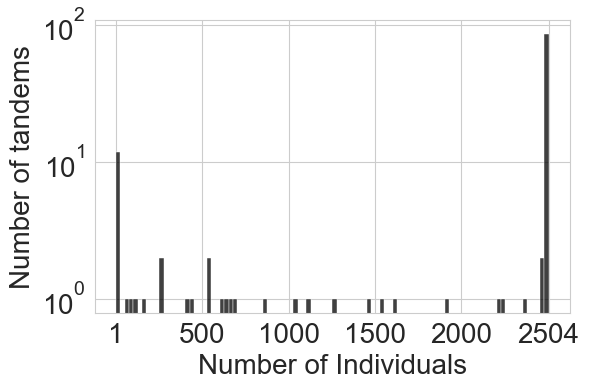

In [25]:


freq_distr = np.sum(k_df[[k for k in k_df.columns if "/" in k]] > 0, axis=0)

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,4))
    sns.histplot(freq_distr, bins=100, color='black')
    plt.xlabel("Number of Individuals", fontsize=20)
    plt.ylabel("Number of tandems", fontsize=20)
    plt.xticks(ticks=[1, 500, 1000, 1500, 2000, 2504],labels=[1, 500, 1000, 1500, 2000, 2504],fontsize=20)
    plt.yticks(fontsize=20)
    plt.yscale('log',base=10)
    plt.tight_layout()
    #plt.savefig('FIG_PLOT_DRAFTS/tandem_sfs.png',dpi=300)
    plt.show()

In [27]:
copies = []
frq_counts = []
monomer_length = []


for kmer in k_counts.index:
    mean_cn = np.mean( (k_counts.loc[kmer] [k_counts.loc[kmer] > 0])  *(len(kmer)-1)/2)
    count = np.sum(k_counts.loc[kmer] > 0)
    monomer_length.append((len(kmer)-1)/2)
    copies.append(mean_cn )
    frq_counts.append(count)

kmer_fs = pd.DataFrame(data={'bp':copies, 'counts':frq_counts, 'ksize':monomer_length})
kmer_fs['freq'] = np.asarray(frq_counts)/2504

bin_var = np.asarray(['Fixed' for k in range(len(frq_counts))])
bin_var[kmer_fs['counts'] < 2504] = 'Variable'

kmer_fs['freq_cat'] = bin_var
kmer_fs['kmer'] = k_counts.index

/var/folders/1w/z1c8vf5d74v001dtwspxw5380000gn/T/ipykernel_80523/3029459288.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = ax.figure.colorbar(sm)


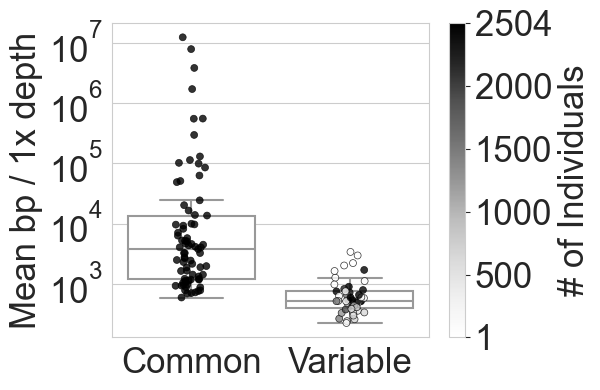

In [28]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(6,4) )
    
    norm = plt.Normalize(kmer_fs['counts'].min(), kmer_fs['counts'].max())
    sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
    sm.set_array([])
    
    ax = sns.stripplot(data=kmer_fs, y='bp', x='freq_cat',linewidth=0.5, edgecolor='black', s=5,
                       alpha=0.8, hue='counts', palette='Greys')
    sns.boxplot(data=kmer_fs, y='bp', x='freq_cat', color='white', showfliers=False)
    plt.ylabel("Mean bp / 1x depth", fontsize=25)
    plt.xlabel("", fontsize=20)

    plt.xticks(ticks = [0,1], labels = ["Common", "Variable"], fontsize=25)

    plt.yticks(fontsize=25)
    plt.yscale('log',base=10)
    ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm)
    cbar.set_ticks([1, 500, 1000, 1500, 2000, 2504])
 #   cbar.set_ticklabels()
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('# of Individuals', fontsize=25)
    
    plt.tight_layout()
    
    plt.show()
    plt.close()

/var/folders/1w/z1c8vf5d74v001dtwspxw5380000gn/T/ipykernel_80523/981535515.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = ax.figure.colorbar(sm)


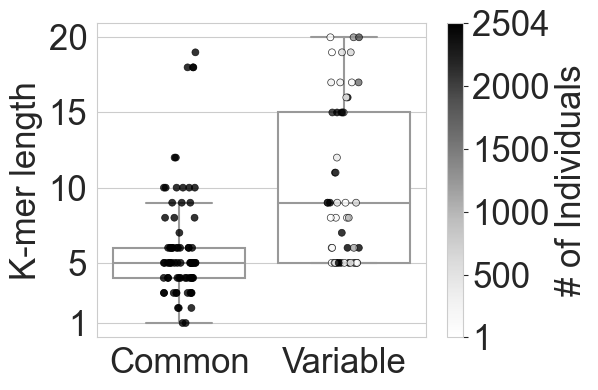

In [29]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(6,4) )
    
    norm = plt.Normalize(kmer_fs['counts'].min(), kmer_fs['counts'].max())
    sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
    sm.set_array([])
    
    ax = sns.stripplot(data=kmer_fs, y='ksize', x='freq_cat',linewidth=0.5, edgecolor='black',
                       s=5, alpha=0.8, hue='counts', palette='Greys')
    sns.boxplot(data=kmer_fs, y='ksize', x='freq_cat', color='white', showfliers=False)
    plt.ylabel("K-mer length", fontsize=25)
    plt.xlabel("", fontsize=25)

    plt.xticks(ticks = [0,1], labels = ["Common", "Variable"], fontsize=25)

    plt.yticks(ticks=[1, 5, 10 , 15, 20],fontsize=25)
    
    ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm)
    cbar.set_ticks([1, 500, 1000, 1500, 2000, 2504])
 #   cbar.set_ticklabels()
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('# of Individuals', fontsize=25)
    
    plt.tight_layout()
    
    plt.show()
    plt.close()

# Figure 2 + SNP-dist network:

This section is going to include code to generate the SNP distance network and the Leiden clustering. The heatmaps are going to be in a seperate Jupyter notebook that is in this folder that uses an R-kernel. That has a different environment and is less likely to conflict this way.

In [86]:
kmers = [k.split("/")[0] for k in k_df.columns[0:126] if len(k) > 7]
kmers_rc = [k.split("/")[1] for k in k_df.columns[0:126] if len(k) > 7]

In [88]:
def calcSteps(aln):
    best_score = np.inf
    
    for aln_iter in aln:
        step_score = 0
        S1 = aln_iter[0]
        S2 = aln_iter[1]
        
        for s in range(aln_iter[4]):
            if S1[s] != S2[s]: #mismatch in alignment of any type:
                #handle gaps
                if S1[s] == "-" or S2[s] == "-": #if gap in either string
                    if s == 0: #if this is first base in sequence then add score
                        step_score += 1
                    else: #handle gap extensions; we consider an extended gap as same mutational space as SNP
                        if S1[s] == "-":
                            if S1[s-1] == "-": #conditional for gap extension in S1
                                pass #if gap is extended do not count additional score
                            elif S1[s-1] != "-":
                                step_score += 1 #if gap is new we add to score
                                
                        #same as S1 but for S2
                        elif S2[s] == "-":
                            if S2[s-1] == "-":
                                pass
                            elif S2[s-1] != "-":
                                step_score += 1
                #handle pure mismatch
                elif S1[s] != '-' and S2[s] != "-":
                    step_score += 1
        best_score = min([best_score, step_score])
        
        if best_score <= 1:
            break
        
    return best_score

The following function looks complex, but its pretty straightforward. It simple iterates through all possible pairwise combinations of both forward and reverse of the monomers AND also all possible sequence offsets. Meaning we compare:

ATA vs GGC
TAT vs GGC
ATT vs GGC

and so on...

The algorithm is designed to escape when we can generate an edge ie when the minimum distance between the two sequences is 1 mutation.

In [89]:
k_steps = np.zeros(shape=(len(kmers), len(kmers)))
kmer_combinations = list(combinations(range(len(kmers)), 2))
for kmer_combo in kmer_combinations:
    i = kmer_combo[0]
    j = kmer_combo[1]
    
    #find shortest and longest:
    if len(kmers[i]) != len(kmers[j]): #this feels extra...
        
        #but basically we find the shortest kmer and then use that to generate the offset bc less options
        shortest_kmer = kmers[kmer_combo[np.argmin([len(kmers[i]), len(kmers[j])])]]
        longest_kmer = kmers[kmer_combo[np.argmax([len(kmers[i]), len(kmers[j])])]]
        shortest_kmer_rc = kmers_rc[kmer_combo[np.argmin([len(kmers[i]), len(kmers[j])])]]
    else:# if theyre the same length its abritrary
        shortest_kmer = kmers[i]
        shortest_kmer_rc = kmers_rc[i]
        longest_kmer = kmers[j]
    #F-F + offsets alignment
    
    for k in range(len(shortest_kmer)):
        kmer_2 = shortest_kmer[k::]+shortest_kmer[0:k]
        alnment1 = pairwise2.align.globalxx(longest_kmer, kmer_2)
        aln_score1 = calcSteps(alnment1)
        
        if aln_score1 <= 1: #escape computation if we can draw edge
            break

    #F-R + all R offsets alnment
    if aln_score1 > 1:
        for k in range(len(shortest_kmer_rc)):
            kmer_2 = shortest_kmer_rc[k::]+shortest_kmer_rc[0:k]
            alnment2 = pairwise2.align.globalxx(longest_kmer, kmer_2)
            aln_score2 = calcSteps(alnment2)
            
            if aln_score2 <= 1: #escape when we can draw edge
                break
                
        best_score = min(aln_score1, aln_score2)
            
    else:
        best_score = aln_score1
    
    k_steps[i,j] = best_score
    k_steps[j,i] = best_score

In [91]:
mutation_graph = pd.DataFrame(data=k_steps, columns=kmers, index=kmers)
adj_matrix = mutation_graph.copy()

adj_matrix[adj_matrix == 0] = 1
adj_matrix[adj_matrix > 1] = 0


A = adj_matrix.copy().values
g = igraph.Graph.Adjacency(A.tolist())
partition = la.find_partition(g, la.ModularityVertexPartition, seed=42)

NTs, cluster_labels = zip(*[(adj_matrix.columns[partition[c]], np.asarray([c for k in range(len(partition[c]))])) for c in range(len(partition))])

NTs = np.concatenate(NTs)
cluster_labels = np.concatenate(cluster_labels)

cluster_df = pd.DataFrame(data={'tandems': NTs, 'label': cluster_labels})

Those are the clusters that we defined in the paper and are described in the main text tables.

Below are the scatterplot of the odds-ratio from the interspersion (how this is calculated is in paper and in a script) and the R2 from the modelling. These are just the summary tables used and am not including the full results of all the models here.

In [94]:
tandem_independence= pd.read_csv("fig_data/2023_05_18.interspersion.OR.csv", index_col = 0)
clustered_r2 = pd.read_csv('fig_data/2023_05_18_kmer.r2.leiden.csv', index_col=0)

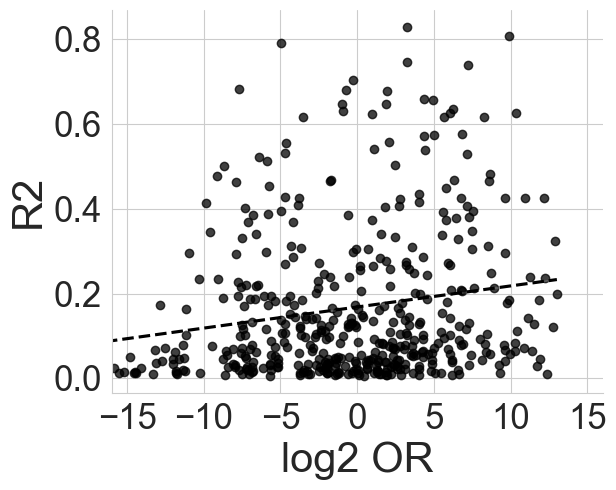

In [95]:
X=np.asarray(tandem_independence.loc[clustered_r2.columns][clustered_r2.columns].values[np.triu_indices(63, 1)])
Y=np.asarray(clustered_r2.values[np.triu_indices(63, 1)])

z = (((((X != 0))*1) + (((Y != 0))*1)) == 2)
#Y=np.triu(clustered_r2)

with sns.axes_style('whitegrid'):

    sns.lmplot(data = pd.DataFrame(data={'odds':np.log2(X[z]), 'r2':Y[z] }), x='odds', y='r2', ci=False,
               line_kws={'color':'black', 'linestyle':"--"}, 
               scatter_kws={"edgecolor":None, 'alpha':0.75, 'color':'black'}, aspect=1.25)
    #plt.ylim(0, 1)
    plt.xlabel("log2 OR", fontsize=30)
    plt.ylabel("R2", fontsize=30)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(-16, 16)
    plt.tight_layout()

    plt.show()
    plt.close()

## Figure 3:

In [19]:
def makePCA(k_df):
    k_counts = k_df.loc[:,k_df.columns[0:126]].T
    
    #transform into basepairs (not relevant), and then Z-normalize (is relevant)
    k_len = [(len(k)-1)/2 for k in k_counts.index]

    k_counts = (k_counts.transpose() *k_len ).transpose()

    m = np.mean(k_counts.values, axis = 1)
    s = np.std(k_counts.values, axis=1)


    pca_counts = ((k_counts.values.transpose() - m) / s).transpose()

    #pca_counts=k_counts
    comps = 4
    pc_fit = PCA(n_components=comps).fit(pca_counts.T)
    components = pc_fit.transform(pca_counts.T)

    #components = TSNE(n_components=comps, init='pca', perplexity=30, random_state=42).fit_transform(pca_counts.T)

    comp_df = pd.DataFrame(data={f"PC{pc+1}":components[:,pc] for pc in range(comps)})

    #print(pc_fit.explained_variance_ratio_)
    #print(np.sum(pc_fit.explained_variance_ratio_))

    comp_df["pop"] = k_df["pop"].values
    comp_df["superpop"] = k_df["superpop"].values

    comp_df.index = k_df.index
    
    return comp_df, pc_fit

In [21]:
pca_df, pca_fit = makePCA(k_df)

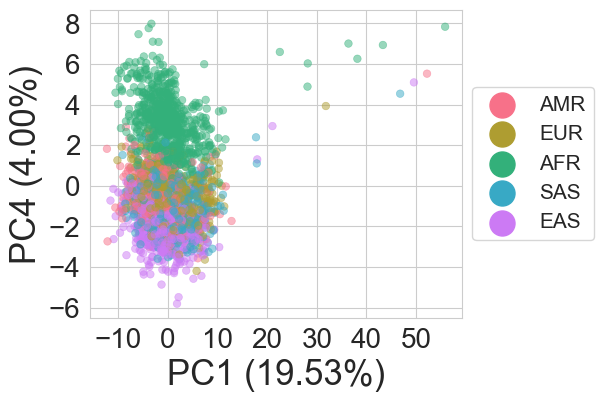

In [24]:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,4))
    ax = fig.subplots(1)
    sns.scatterplot(data=pca_df, x="PC1", y="PC4", hue='superpop',palette='husl',hue_order=["AMR", "EUR", "AFR","SAS","EAS"], edgecolor=None, alpha=0.5,ax=ax, s=30)
    plt.xlabel("PC1 (19.53%)", fontsize=25)
    plt.ylabel('PC4 (4.00%)', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3, fontsize=15)
    #plt.tight_layout(w_pad=100)
    
    plt.show()
    plt.close()

In [107]:
def plot_popTandem(tandem, save=False, scale=False):
    k_df = pd.read_csv("Supplemental_Table_1.csv", index_col=0)
    with sns.axes_style('whitegrid'):
    #sns.violinplot(data=k_clean_df, x='super_pop', y='ACAG/CTGT', order=['AFR', 'AMR', 'SAS', 'EUR', 'EAS'], color='white', showfliers=False)
        sns.boxplot(data=k_df, x='superpop', y=tandem, order=["AMR", "EUR", "AFR", "SAS", "EAS"], 
                    showfliers=True, palette="husl", hue_order=[])
        #sns.stripplot(data=k_clean_df, x='super_pop', y=tandem, order=["AMR", "EUR", "AFR", "SAS", "EAS"], color='black', alpha=0.2)
        plt.yticks(fontsize=25)
        if scale:
            plt.yscale('log', base=10)
        plt.xticks( ticks=[0,1,2,3,4], fontsize=25) #labels=["America", "Europe", "Africa",'S. Asia', "E. Asia" ],
        plt.xlabel('')
        plt.ylabel(f'Copies/1x depth', fontsize=25)
        plt.title(f'{tandem}', fontsize=25)
        plt.tight_layout()
        if save:
            plt.savefig(f"{tandem.split('/')[0]}.pop.png", dpi=300)
        plt.show()
        plt.close()

In [108]:
pc4_features = np.abs(pca_fit.components_[3]).argsort()[::-1]

In [109]:
top_pc_tandems = k_df.columns[pc4_features]

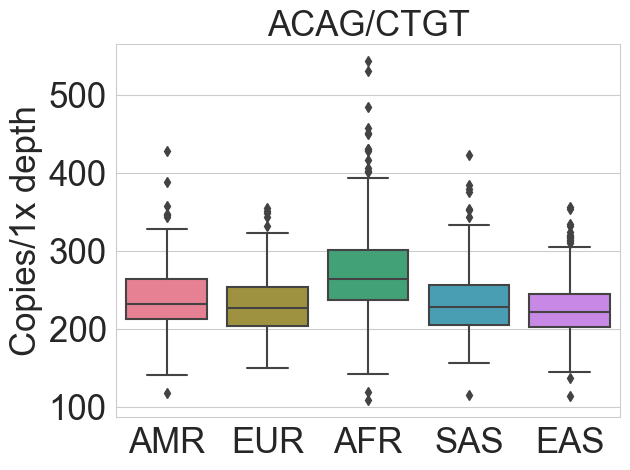

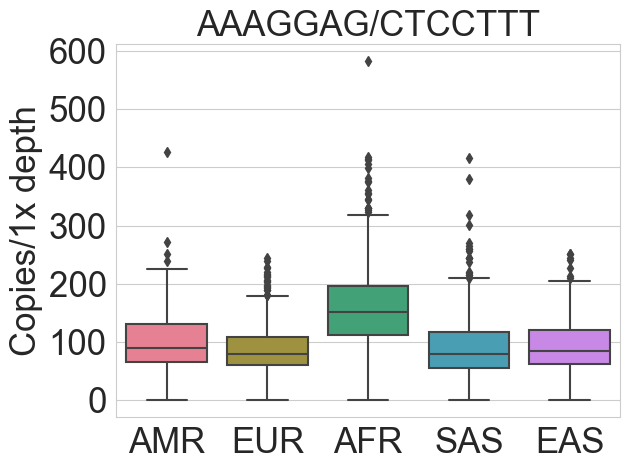

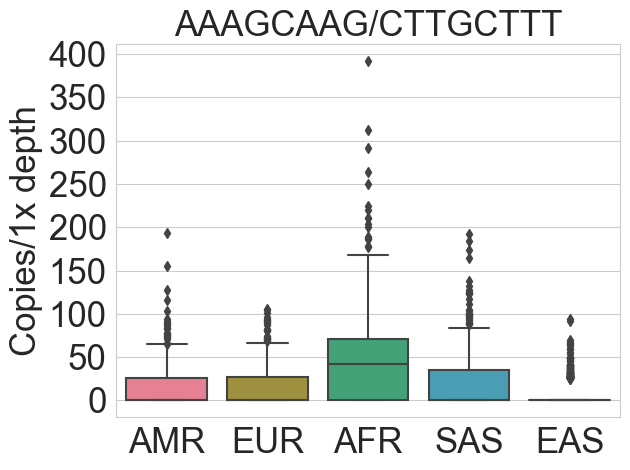

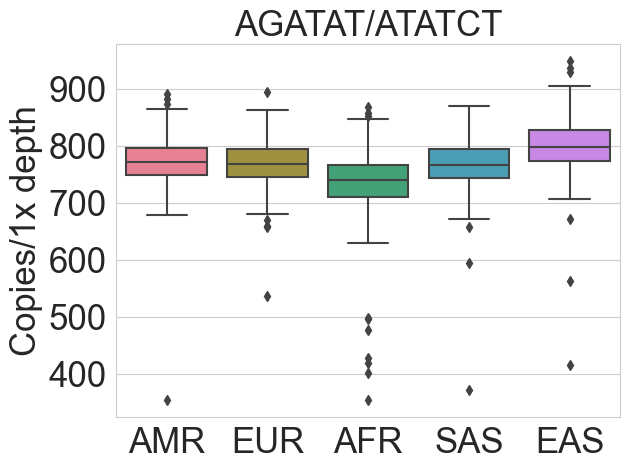

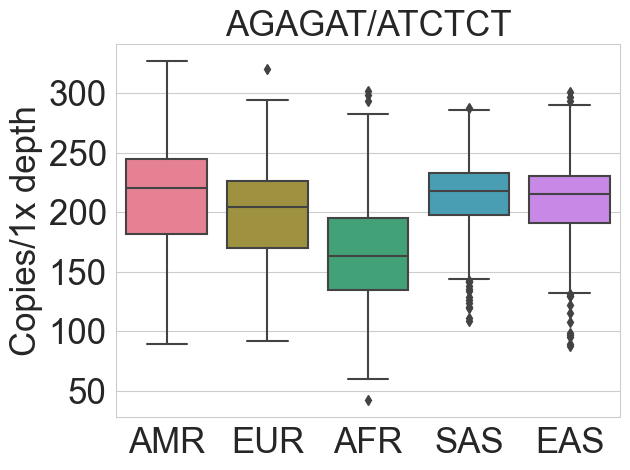

In [110]:
for p in top_pc_tandems[0:5]:
    plot_popTandem(p)

In [111]:
metadata = pd.read_csv('fig_data/2023_03_22.1KGP.metadata.csv', index_col = 0)
model_results = pd.read_csv("fig_data/pop.fe.model.results.csv", index_col=0)


In [129]:
model_results.columns = [k.replace('.','/') for k in model_results.columns]

k_df = k_df.loc[metadata.index]

k_df['superpop'] = metadata['superpop']

pop_label_order = np.asarray([group[0] for group in k_df.groupby('superpop')])

pop_means = pd.concat([np.mean(group[1][model_results.columns],axis=0) for group in k_df.groupby('superpop')],axis=1)



abs_diff = np.max([abs(np.max(pop_means,axis=1)-np.mean(pop_means,axis=1)), abs(np.min(pop_means,axis=1)-np.mean(pop_means,axis=1))],axis=0)

model_results.loc['absdiff'] = abs_diff
model_results.loc['logp'] = -np.log10(model_results.loc['pval'].values.astype(float))

model_results.loc['threshold'] = ['n.s.' if p > (0.05/77) else "sig." for p in model_results.loc['pval']]

model_results.loc['global_mean'] = np.mean(pop_means,axis=1)

sortedMeans = pd.DataFrame(data=np.argsort(abs(np.mean(pop_means,axis=1) - pop_means.transpose()),axis=0), columns=pop_means.index)
sortedMeans
diffmeans = [pop_means.iloc[i][sortedMeans[sortedMeans.columns[i]]].values[-1] for i in range(77)]
pop_label_diff = [pop_label_order[sortedMeans[sortedMeans.columns[i]]][-1] for i in range(77)]
model_results.loc['diffmeans'] = diffmeans
model_results.loc['diff_pop'] = pop_label_diff

model_results.loc['differences'] = model_results.loc['diffmeans'] - model_results.loc['global_mean']

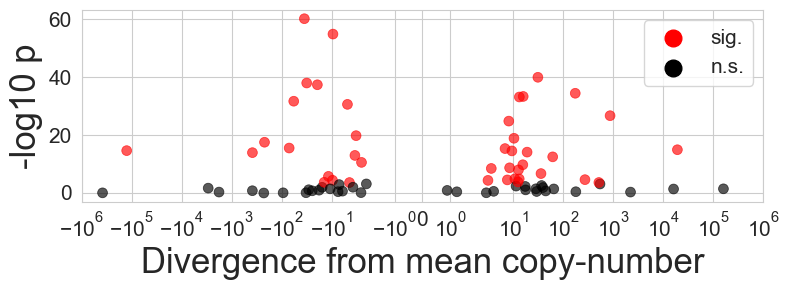

In [132]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(8,3))
    sns.scatterplot(data=model_results.transpose(), x='differences', y='logp', alpha=0.65, edgecolor=None,
                   hue='threshold', palette=['red', 'black'], hue_order=['sig.', 'n.s.'], s=50)
    plt.xscale('symlog', base=10)
    plt.xlabel("Divergence from mean copy-number", fontsize=25)
    plt.ylabel('-log10 p', fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15, markerscale=2)
    plt.xlim(-10**6, 10**6)
    plt.tight_layout()
    #plt.savefig("pop.struct.model.volcano.png",dpi=300)
    plt.show()
    plt.close()

# Figure 5

In [145]:
cen_annot = pd.read_csv('fig_data/chm13.draft_v2.0.cen_mask.bed', sep='\t', header=None)
censats = ["AATGG", "AATCGAATGG", "AATGGAATGGAGTGG", "ACTCC"]

In [146]:

centro = [f"chr{c+1}" for c in range(22)]
var_df = pd.DataFrame(data=np.full(shape=(22,4), fill_value=np.nan), columns=censats, index=centro)
pval_df = pd.DataFrame(data=np.full(shape=(22,4), fill_value=np.nan), columns=censats, index=centro)
resid_df = pd.DataFrame(data=np.full(shape=(22,4), fill_value=np.nan), columns=censats, index=centro)

for sat in censats:
    for chrom in centro:
        if chrom not in ["chr15", "chr16"]: #use 1Mb annotations for all except chr15 and chr16 use 2.5Mb bc convergence issues
            data = pd.read_csv(f'fig_data/varparts/{sat}.{chrom}.hsq', sep='\t', index_col=0)
            var_df.loc[chrom][sat] = data.loc["V(G)/Vp"]["Variance"]
            pval_df.loc[chrom][sat] = data.loc["Pval"]["Variance"]
            resid_df.loc[chrom][sat] = data.loc["V(e)"]["Variance"] / data.loc["Vp"]["Variance"]
        else:
            data = pd.read_csv(f'fig_data/varparts/{sat}.{chrom}.2.5Mb.hsq', sep='\t', index_col=0)
            var_df.loc[chrom][sat] = data.loc["V(G)/Vp"]["Variance"]
            pval_df.loc[chrom][sat] = data.loc["Pval"]["Variance"]
            resid_df.loc[chrom][sat] = data.loc["V(e)"]["Variance"] / data.loc["Vp"]["Variance"]

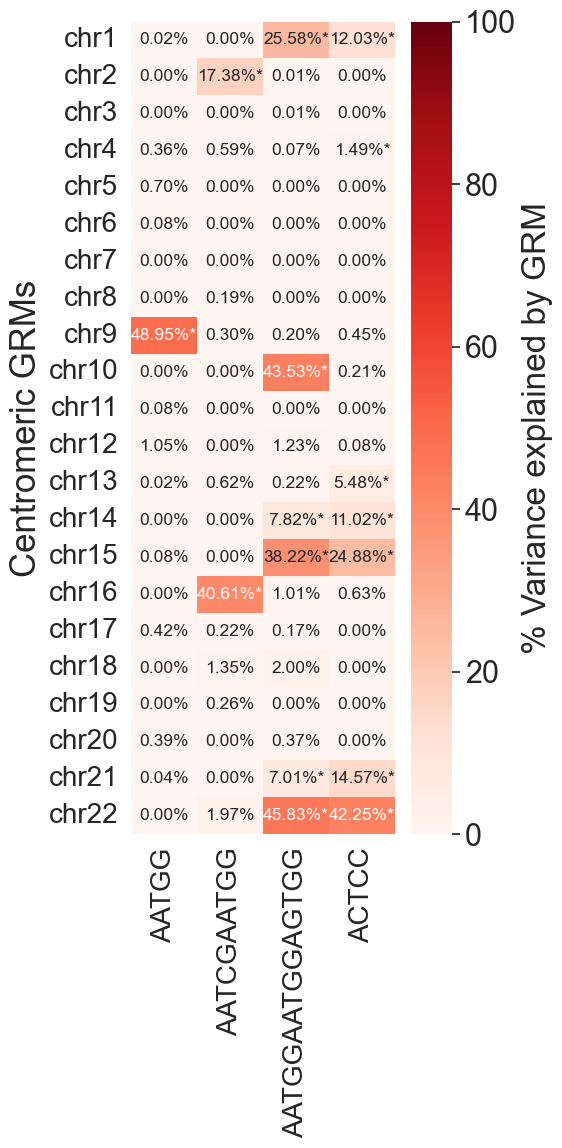

In [147]:
lf_var_df = pd.DataFrame()

varp = np.concatenate([var_df[c] for c in var_df.columns])
kmers = np.concatenate([[c for k in range(22)] for c in var_df.columns])
chrom = np.concatenate([[f"chr{k+1}" for k in range(22)] for c in var_df.columns])
p = np.concatenate([pval_df[c] for c in var_df.columns])

lf_var_df['var_exp'] = varp
lf_var_df['pval'] = p
lf_var_df['censat'] = kmers
lf_var_df['chrom'] = chrom
sig = np.asarray(["n.s." for p in range(88)])
sig[lf_var_df['pval'] < (0.05/88)] = 'sig.'
lf_var_df['threshold'] = sig

annot_mat = np.full(fill_value="empty", shape=(22,4), dtype=object)
for i in range(4):
    for j in range(22):
        annot_mat[j,i] = f"{var_df.iloc[j][var_df.columns[i]]*100:0.2f}%"


annot_mat[pval_df.values < (0.05/88)] = annot_mat[pval_df.values < (0.05/88)] + "*"

fig = plt.figure(figsize=(6,12))
sns.set(font_scale=2)
sns.heatmap(var_df*100, cmap='Reds', fmt='', annot_kws={'fontsize':12.5}, vmin=0, vmax=100, annot=annot_mat,
           cbar_kws={"format":"%.0f", "label":"% Variance explained by GRM"})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("")
plt.ylabel("Centromeric GRMs", fontsize=25)
plt.tight_layout()
#plt.savefig("cenGRM.varExp.png", dpi=300)
plt.show()
plt.close()

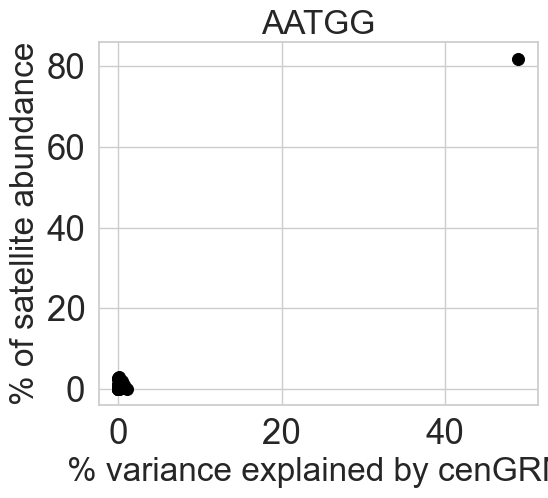

SignificanceResult(statistic=0.21530358626246604, pvalue=0.3359163528773209)


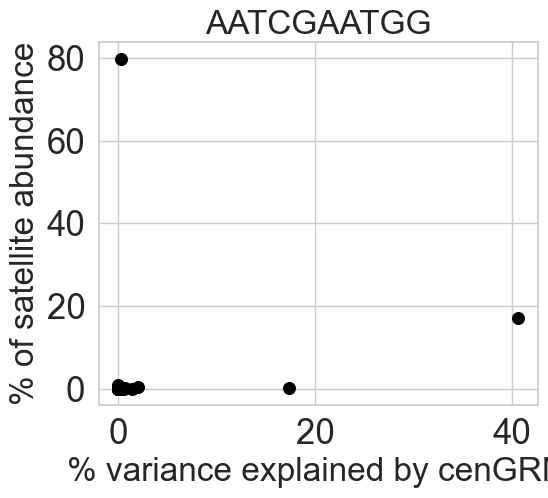

SignificanceResult(statistic=0.21645546930543183, pvalue=0.33327457091761414)


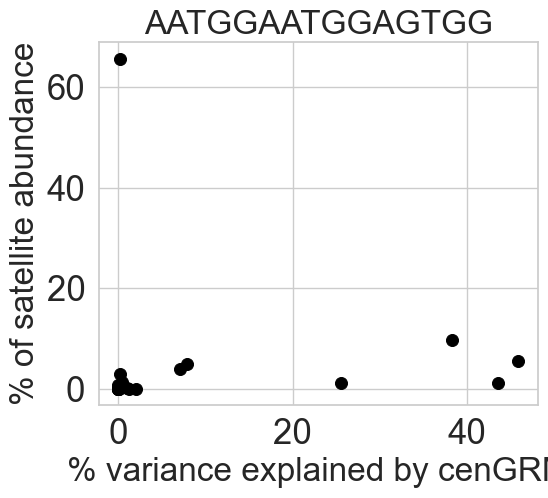

SignificanceResult(statistic=0.6186635944700462, pvalue=0.0021451953272547306)


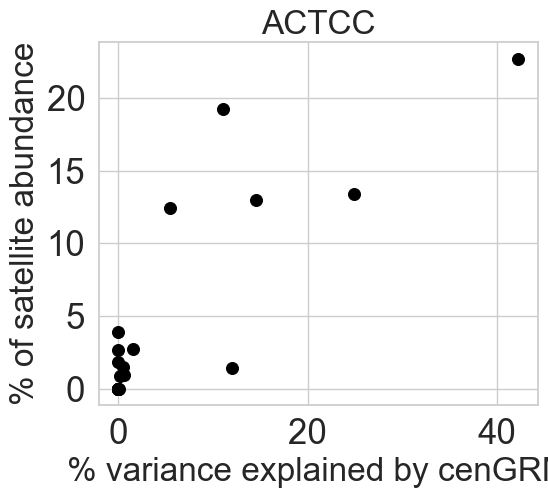

SignificanceResult(statistic=0.7442731055204298, pvalue=7.135495553648156e-05)


In [148]:
cendat = {seq:[] for seq in censats}

for sat in censats:
    kdense = np.load(f"fig_data/{sat}.100000_100000.kmerDensity.npz")
    T = 0
    sat_counts = []
    for cen_seq in range(22):

        cen_bounds = ( max([0 , int(cen_annot.iloc[cen_seq][1] / 100000) -10] ), (int(cen_annot.iloc[cen_seq][2] / 100000))+10)
        
        kmer_counts = np.sum(kdense[cen_annot.iloc[cen_seq][0]] [cen_bounds[0]: cen_bounds[1]])
        T += np.sum(kdense[cen_annot.iloc[cen_seq][0]])

        sat_counts.append(kmer_counts)
        
    M = ~np.isnan(var_df[sat])

    prop_total = np.asarray(sat_counts)[M]/T
    cendat[sat] = np.asarray(sat_counts)/T
    
    with sns.axes_style('whitegrid'):
        fig = plt.figure(figsize=(6,5.5))
        sns.scatterplot(data=pd.DataFrame(data={"var":var_df[sat].values[M]*100, "sat":prop_total*100}),
                        x='var', y='sat', edgecolor=None, color='black', s=75)
        #sns.lmplot(data=pd.DataFrame(data={"var":var_df[sat].values[M], "sat":prop_total}),x='var', y='sat', ci=False, line_kws={'linestyle':'--', "color":'black'},scatter_kws={'color':'black'})
        plt.xlabel('% variance explained by cenGRM')
        plt.ylabel("% of satellite abundance")
        plt.title(sat)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        #plt.ylim(-0.1,0.5)
        #plt.xlim(-0.1,0.5)
        plt.tight_layout()
        plt.savefig(f"{sat}.cenGRM.cenCN.png",dpi=300)
        plt.show()
        plt.close()
        
    print(spearmanr(var_df[sat].values[M], prop_total))

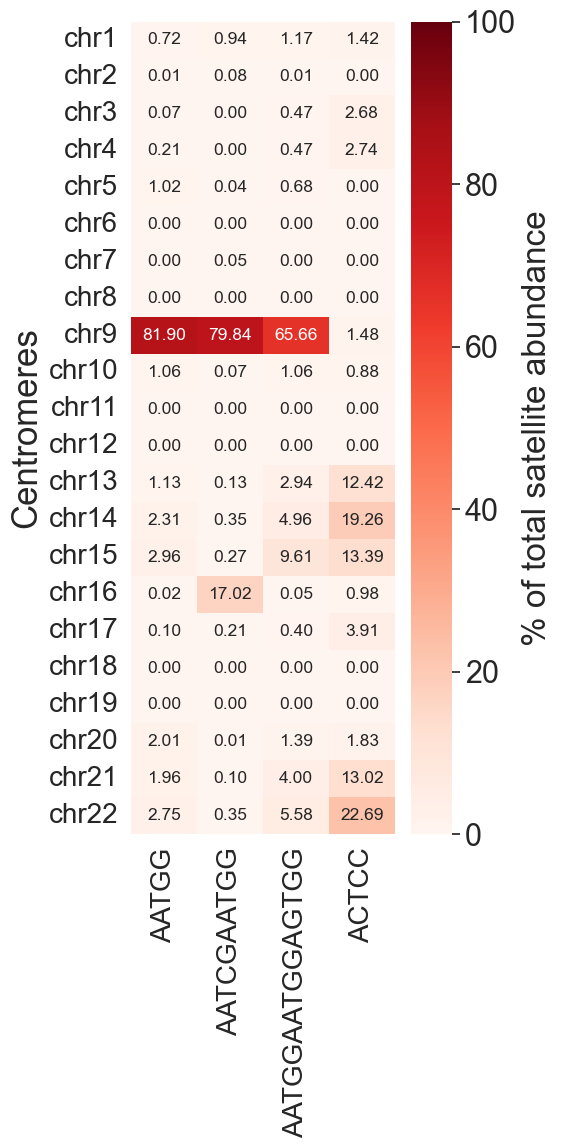

In [149]:
cen_df = pd.DataFrame(data=cendat)
cen_df.index = [f"chr{cen_seq+1}" for cen_seq in range(22)]

fig = plt.figure(figsize=(6,12))
sns.set(font_scale=2)
sns.heatmap(cen_df*100, cmap='Reds', fmt='.02f', annot_kws={'fontsize':12.5}, vmin=0, vmax=100, annot=cen_df*100,
           cbar_kws={"format":"%.0f", "label":"% of total satellite abundance"})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("")
plt.ylabel("Centromeres", fontsize=25)
plt.tight_layout()
#plt.savefig("cenAbundance.hmap.png", dpi=300)
plt.show()
plt.close()

# Figure 6

In [150]:
k_cluster_df = pd.read_csv('fig_data/kmer_counts.clabel.csv', index_col=0)

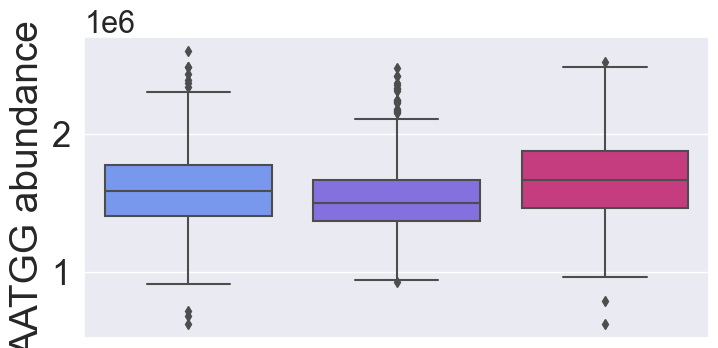

In [152]:
fig = plt.figure(figsize=(8,4))
sns.boxplot(data=k_cluster_df, x='chr9_centro', y='AATGG.CCATT', order=[1,2,3], 
            palette=['#648FFF', "#785EF0", "#DC267F"])

#sns.stripplot(data=afr_clust, x='chr16_cluster', y= 'hsat2', color='black', order=[2,9, 8], alpha=0.5)
plt.xlabel('')
plt.yticks(fontsize=25)
plt.ylabel('AATGG abundance', fontsize=28)
plt.xticks(ticks=[0,1,2], labels=["","",""])
plt.tight_layout()
#plt.savefig('chr9.clades.hsat3.png',dpi=300)
plt.show()
plt.close()

In [167]:
for group in k_cluster_df.groupby('chr9_centro'):
    print(np.mean(group[1]['AATGG.CCATT']), group[0])

1597093.7744576843 1
1526632.679204529 2
1670137.7720247721 3


In [169]:
sp.mannwhitneyu(k_cluster_df[k_cluster_df['chr9_centro'] == 3]["AATGG.CCATT"], k_cluster_df[k_cluster_df['chr9_centro'] == 1]['AATGG.CCATT'])

MannwhitneyuResult(statistic=348928.0, pvalue=4.3913379608289265e-07)

In [175]:
afr_clust = k_cluster_df.iloc[[i for i in range(2504) if (k_cluster_df['chr16_centro'].iloc[i] in [2, 8, 9])]][['AATCGAATGG.CCATTCGATT', 'chr16_centro']]
non_afr = k_cluster_df.loc[k_cluster_df.index.difference(afr_clust.index), ['AATCGAATGG.CCATTCGATT']]
non_afr['chr16_centro'] = [1 for i in range(non_afr.shape[0])]
afr_clust = pd.concat((afr_clust, non_afr))
non_afr = k_cluster_df.loc[k_cluster_df.index.difference(afr_clust.index), ['AATCGAATGG.CCATTCGATT']]
non_afr['chr16_centro'] = [1 for i in range(non_afr.shape[0])]
afr_clust = pd.concat((afr_clust, non_afr))
afr_clust.columns = ["hsat2", 'chr16_cluster']


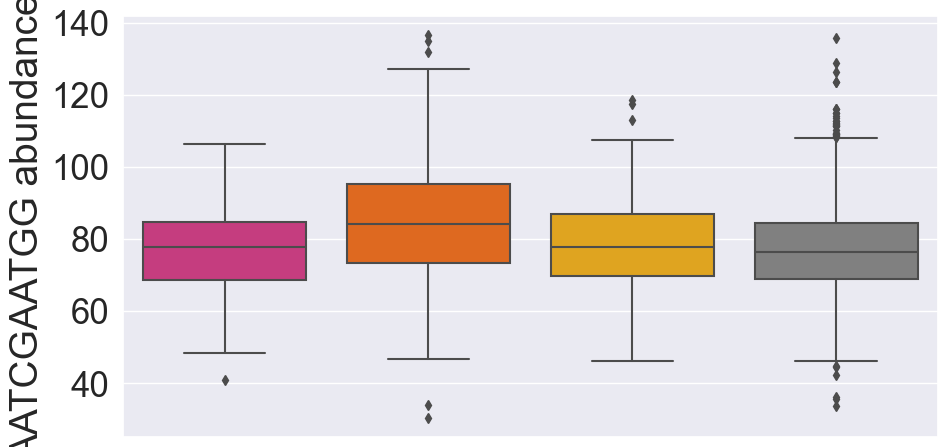

In [176]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(data=afr_clust, x='chr16_cluster', y= 'hsat2', palette=['#DC267F', "#FE6100", "#FFB000", '#808080'], 
            order=[2, 8, 9, 1])
#sns.stripplot(data=afr_clust, x='chr16_cluster', y= 'hsat2', color='black', order=[2,9, 8], alpha=0.5)
plt.xlabel('')
plt.yticks(fontsize=25)
plt.ylabel('AATCGAATGG abundance', fontsize=28)
plt.xticks(ticks=[0,1,2,3], labels=["","","",""])
plt.tight_layout()
#plt.savefig('afr.clades.hsat2.png',dpi=300)
plt.show()
plt.close()